In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
! pip install -q keras


In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNLES = 3
EPOCHs = 30

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Project_2",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)   ### length is 68 becaause the dataset is in batch size of 32 i.e. 2152/32

68

In [8]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())


[[[159. 157. 168.]
  [159. 157. 168.]
  [160. 158. 169.]
  ...
  [170. 167. 174.]
  [141. 138. 145.]
  [166. 163. 170.]]

 [[158. 156. 167.]
  [158. 156. 167.]
  [159. 157. 168.]
  ...
  [158. 155. 162.]
  [129. 126. 133.]
  [155. 152. 159.]]

 [[157. 155. 166.]
  [158. 156. 167.]
  [158. 156. 167.]
  ...
  [212. 209. 216.]
  [125. 122. 129.]
  [182. 179. 186.]]

 ...

 [[132. 127. 133.]
  [132. 127. 133.]
  [131. 126. 132.]
  ...
  [134. 125. 128.]
  [132. 123. 126.]
  [132. 123. 126.]]

 [[136. 131. 137.]
  [136. 131. 137.]
  [135. 130. 136.]
  ...
  [137. 128. 131.]
  [138. 129. 132.]
  [141. 132. 135.]]

 [[135. 130. 136.]
  [136. 131. 137.]
  [136. 131. 137.]
  ...
  [139. 130. 133.]
  [136. 127. 130.]
  [135. 126. 129.]]]


In [9]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.numpy().shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 2 2 1 0 1 1 0 1 0 0 1 1 1 1 1]


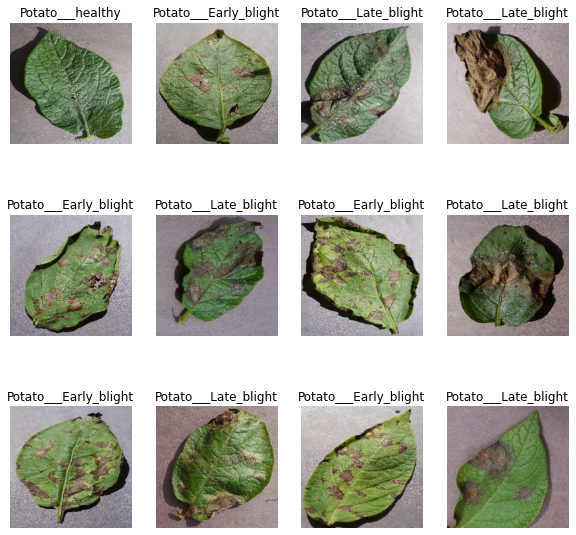

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

  
  


In [11]:
len(dataset)

68

In [12]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
test_ds =dataset.skip(54)
len(train_ds)



54

In [15]:
len(test_ds)

14

In [16]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=1000):
  ds_size = len(ds)

  if shuffle:
      ds = ds.shuffle(shuffle_size,seed = 12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)
  test_size = int(test_split*ds_size)
  
  train_ds = ds.take(train_size)
  val_ds =ds.skip(train_size).take(val_size)
  test_ds =ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)


In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# Data preprocessing
rescale_and_resize =tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1/255)
])

In [26]:
#Data Augmentation (To make model robust i.e if we supply image which is rotated/contrast, the model will not work properly.So in order to solve that we use DA)
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNLES)
n_clases = 3 #Last layer will have 3 neurons
## Model Creation
model = models.Sequential([
                          rescale_and_resize,
                          data_augmentation,
                          layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(64,kernel_size=(3,3),activation ='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(64,kernel_size=(3,3),activation ='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(64,(3,3),activation ='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(64,(3,3),activation ='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(64,(3,3),activation ='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Flatten(),
                          layers.Dense(64,activation='relu'),
                          layers.Dense (n_clases,activation='softmax'),
])
model.build(input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [29]:
model.compile(
               optimizer='adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics = ['accuracy']

              )

In [30]:
history = model.fit(
                      train_ds,
                      epochs = EPOCHs,
                      batch_size = BATCH_SIZE,
                      verbose =1,
                      validation_data = val_ds
                  )

Epoch 1/30
54/54 [==============================] - 206s 4s/step - loss: 0.9020 - accuracy: 0.4896 - val_loss: 0.8253 - val_accuracy: 0.5104
Epoch 2/30
54/54 [==============================] - 180s 3s/step - loss: 0.7918 - accuracy: 0.6267 - val_loss: 0.9682 - val_accuracy: 0.5938
Epoch 3/30
54/54 [==============================] - 178s 3s/step - loss: 0.5653 - accuracy: 0.7598 - val_loss: 0.3363 - val_accuracy: 0.8750
Epoch 4/30
54/54 [==============================] - 177s 3s/step - loss: 0.3927 - accuracy: 0.8385 - val_loss: 0.2624 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 178s 3s/step - loss: 0.2783 - accuracy: 0.8970 - val_loss: 0.1938 - val_accuracy: 0.9167
Epoch 6/30
54/54 [==============================] - 180s 3s/step - loss: 0.2504 - accuracy: 0.9068 - val_loss: 0.2706 - val_accuracy: 0.8906
Epoch 7/30
54/54 [==============================] - 177s 3s/step - loss: 0.2359 - accuracy: 0.9091 - val_loss: 0.1733 - val_accuracy: 0.9167
Epoch 8/30
54

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 11s 777ms/step - loss: 0.0523 - accuracy: 0.9766


In [32]:
scores

[0.0522698350250721, 0.9765625]

In [33]:
history

In [34]:
history.params

{'epochs': 30, 'steps': 54, 'verbose': 1}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
loss = history.history['loss']

Text(0.5, 1.0, 'Training and Validation Loss')

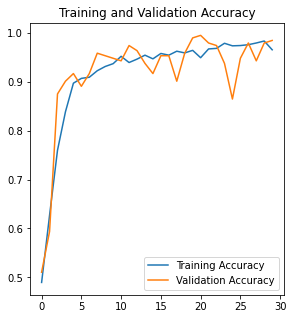

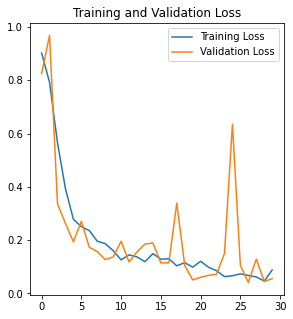

In [37]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHs), acc, label ='Training Accuracy')
plt.plot(range(EPOCHs), val_acc, label ='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.figure(figsize = (10,5))


plt.subplot(1,2,2)
plt.plot(range(EPOCHs), loss, label ='Training Loss')
plt.plot(range(EPOCHs), val_loss, label ='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image to Predict:
actual_label: Potato___Late_blight
Predicted Label Name: Potato___Late_blight


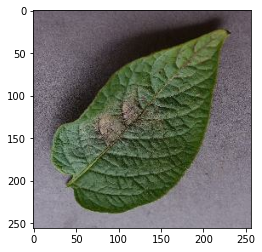

In [38]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print("First Image to Predict:")
  plt.imshow(first_image)
  print("actual_label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label Name:",class_names[np.argmax(batch_prediction[0])])



In [39]:
###Function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


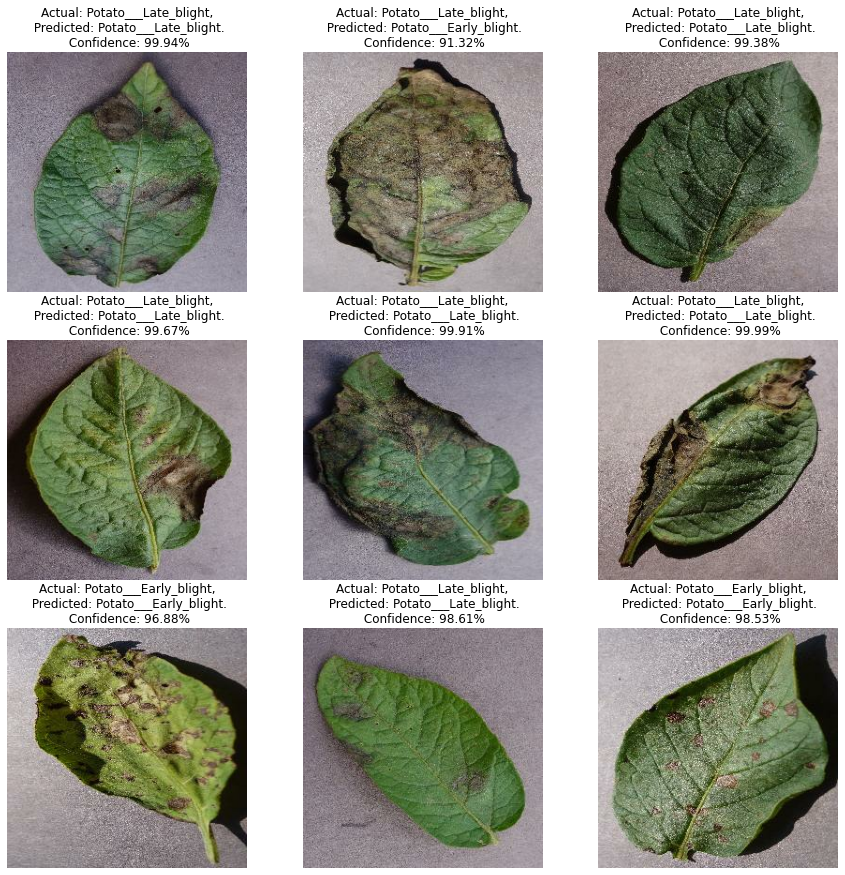

In [40]:
### Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
model_version  = 1
model.save("/content/drive/MyDrive/Colab Notebooks/Model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Model/assets
